In [1]:
import time
import torch
import torch.nn as nn

from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import MarianMTModel, MarianTokenizer
from tensorly.decomposition import tucker
import tensorly as tl
from transformers import pipeline
import sacrebleu
import copy

tl.set_backend('pytorch')

In [2]:
!pip install sentencepiece
!pip install sacremoses


In [3]:
def translate(model, text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    outputs = model.generate(**inputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def measure_time_and_quality(model, prompt, tokenizer):
    start_time = time.time()
    generated_text = translate(model, prompt, tokenizer)
    generation_time = time.time() - start_time
    return generated_text, generation_time

def measure_memory(model):
    total_params = sum(p.numel() for p in model.parameters())

    return total_params

In [4]:
model_name = "Helsinki-NLP/opus-mt-en-ru"
original_model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

In [5]:
import torch
import torch.nn as nn
import tensorly as tl
from tensorly.decomposition import tensor_train
from tensorly.tt_tensor import tt_to_tensor


class TTCompressedLinear(nn.Module):
    def __init__(self, original_weight, tt_rank, bias=None):
        super(TTCompressedLinear, self).__init__()
        self.input_dim, self.output_dim = original_weight.shape

        self.tt_cores = tensor_train(original_weight, rank=tt_rank)

        self.bias = nn.Parameter(bias) if bias is not None else None

    def reconstruct_weights(self):
        return tt_to_tensor(self.tt_cores)

    def forward(self, x):
        weights = self.reconstruct_weights()
        output = x @ weights.T
        if self.bias is not None:
            output += self.bias
        return output


def compress_model_with_tt(model, tt_rank):
    for name, layer in model.named_modules():
        if "lm_head" in name:
            continue
        
        if isinstance(layer, nn.Linear):
            bias = layer.bias.data if layer.bias is not None else None

            with torch.no_grad():
                original_weight = layer.weight.data
                new_layer = TTCompressedLinear(
                    original_weight=original_weight,
                    tt_rank=tt_rank,
                    bias=bias
                )
                parent_module, layer_name = _get_parent_module(model, name)
                setattr(parent_module, layer_name, new_layer)
    return model


def _get_parent_module(model, module_name):
    parts = module_name.split(".")
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    return parent, parts[-1]


In [6]:
prompt = "The weather is beautiful today."
reference = [
    "Сегодня прекрасная погода.",
    "Погода сегодня чудесная.",
    "Сегодня замечательная погода.",
    "Погода сегодня прекрасная.",
    "Сегодня хорошая погода.",
    "Погода сегодня хорошая.",
    "Сегодня отличная погода.",
    "Погода сегодня отличная.",
    "Погода сегодня прекрасна.",
]

'''prompt = "My heart sank a bit when I went down again the next day and saw him back in the same position again. By now he was slightly more vulnerable and dishevelled than before. He looked cold and hungry and he was shaking a little."
reference = [
    "Моё сердце сжалось, когда я снова спустился на следующий день и увидел его в том же положении. Теперь он выглядел ещё более уязвимым и потрёпанным, чем раньше. Он казался замёрзшим и голодным, и немного дрожал.",
    "На следующий день, спустившись вниз, я снова увидел его в том же состоянии, и моё сердце сжалось. Теперь он выглядел ещё более уязвимым и несчастным. Он замерзал, был голоден и слегка дрожал.",
    "Когда я снова спустился вниз на следующий день и увидел его в той же позе, моё сердце болезненно сжалось. Он выглядел ещё более ослабленным и растрёпанным, чем раньше. Он дрожал, был голоден и явно замёрз.",
    "Моё сердце упало, когда я на следующий день снова увидел его в том же положении. Теперь он выглядел слабее и грязнее. Он, похоже, замерзал, дрожал и выглядел голодным.",
    "Спустившись на следующий день, я заметил, что он всё ещё сидит в той же позе, что и раньше. Моё сердце сжалось от этого зрелища. Он выглядел хуже, чем накануне: ослабленный, голодный и дрожащий от холода.",
    "На следующий день я увидел его снова в том же месте. Моё сердце упало. Он выглядел слабее, голодным и дрожал от холода.",
    "Моё сердце сжалось, когда на следующий день я снова увидел его там же. Он выглядел ещё более уязвимым, грязным и голодным. Он дрожал, словно замерзал.",
    "Когда я спустился на следующий день, он всё ещё сидел на том же месте, и моё сердце болезненно сжалось. Он выглядел слабее и, казалось, замерзал. Он дрожал, и видно было, что он очень голоден.",
    "На следующий день я снова увидел его в том же месте, и мне стало жаль его ещё больше. Он выглядел плохо: слабый, дрожащий, голодный и замёрзший.",
    "На следующий день я снова спустился и увидел его на том же месте. Моё сердце сжалось: он выглядел ещё более голодным, слабым и замёрзшим, чем раньше.",
    "Когда я снова спустился вниз на следующий день, я увидел его в том же положении. Моё сердце сжалось: он был голодным, холодным и слабым.",
    "На следующий день, спустившись, я снова увидел его. Моё сердце упало, потому что он выглядел слабее и замёрзшим. Он дрожал и казался голодным.",
    "Моё сердце сжалось, когда я на следующий день снова увидел его. Он был в той же позе, выглядел слабым, голодным и дрожал от холода.",
    "Когда я на следующий день снова спустился вниз, я увидел его там же. Моё сердце болезненно сжалось. Он выглядел ещё хуже: ослабевший, дрожащий и голодный.",
    "На следующий день я снова увидел его, и мне стало очень жаль. Моё сердце сжалось, потому что он выглядел замёрзшим, дрожал и явно был голоден."
]'''

'''prompt = """
As we approached the end of Bob’s second week of medication, he was looking a lot brighter. The wound at the back of his leg was healing nicely and the bald and thin patches on his coat had begun to disappear and were being replaced with new, thicker fur. He also seemed happier in his face, his eyes had a more lustrous gleam to them. There was a beautiful, green and yellow glow to them that hadn’t been there before.

He was definitely on the road to recovery, and his boisterousness around the flat was the ultimate proof of it. He had been a whirling dervish, flying around the place since day one, but in the past week or so he’d become even more of a ball of energy. I hadn’t thought it possible. There were times when he would jump and run around the place like some kind of maniac. He would claw furiously at everything and anything he could find, including me.

There were scratches on every wooden surface in the flat. I even had scratches on the back of my hand and arm. I didn’t mind, I knew it wasn’t malicious and that he was only playing.
"""

# Список переводов
reference = [
    """
К концу второй недели лечения Боб выглядел намного лучше. Рана на задней лапе заживала, а лысины и тонкие участки на его шерсти начали исчезать, сменяясь новой, более густой шерстью. Он выглядел счастливее, его глаза сияли ярким блеском. В них появилась красивая зелено-желтая искра, которой раньше не было.

Он явно шел на поправку, и его резвость в квартире была лучшим доказательством этого. С самого первого дня он был настоящим вихрем, но за последнюю неделю стал еще более энергичным. Я не думал, что это возможно. Иногда он прыгал и носился по комнате, как настоящий безумец. Он яростно царапал все, что попадалось под лапы, включая меня.

На каждой деревянной поверхности в квартире появились царапины. Даже на тыльной стороне моей руки и предплечья были следы от его когтей. Но мне было все равно, я знал, что он делал это не со зла, а просто играл.
""",
    """
К завершению второй недели лечения Боб выглядел гораздо лучше. Рана на задней лапе хорошо заживала, а залысины и редкие участки шерсти постепенно заменялись густым новым покровом. Он выглядел довольным, его глаза сверкали ярким блеском. В них появился яркий зеленовато-желтый оттенок, который раньше я не замечал.

Было очевидно, что он идет на поправку. Его активность в квартире была лучшим подтверждением этому. С первого дня он был непоседливым, но за последнюю неделю его энергия стала еще больше. Иногда он бегал и прыгал по квартире, словно сумасшедший. Он нещадно царапал все, что попадалось ему на пути, включая меня.

Деревянные поверхности в квартире были испещрены царапинами. Даже на моих руках и запястьях появились следы его когтей. Я не обижался, потому что знал, что он делает это не специально, а просто резвится.
""",
    """
Ближе к концу второй недели лечения Боб начал выглядеть значительно лучше. Рана на задней лапе заживала, а тонкие и залысевшие места на его шерсти начали обрастать густой и новой шерстью. Его лицо выглядело счастливее, а в глазах появился новый яркий блеск. Теперь они светились красивым зеленовато-желтым оттенком, которого раньше не было.

Его выздоровление было очевидным, а его бурная активность в квартире стала тому доказательством. Он был невероятно энергичным с самого начала, но за последнюю неделю стал еще более живым. Иногда он носился по квартире и прыгал, как настоящий маньяк. Он активно царапал все, что попадалось ему под лапы, даже меня.

Вся деревянная мебель в квартире была покрыта царапинами. На тыльной стороне моей руки и предплечья тоже появились следы его когтей. Я не злился, понимая, что он просто играет.
"""
]'''



'prompt = """\nAs we approached the end of Bob’s second week of medication, he was looking a lot brighter. The wound at the back of his leg was healing nicely and the bald and thin patches on his coat had begun to disappear and were being replaced with new, thicker fur. He also seemed happier in his face, his eyes had a more lustrous gleam to them. There was a beautiful, green and yellow glow to them that hadn’t been there before.\n\nHe was definitely on the road to recovery, and his boisterousness around the flat was the ultimate proof of it. He had been a whirling dervish, flying around the place since day one, but in the past week or so he’d become even more of a ball of energy. I hadn’t thought it possible. There were times when he would jump and run around the place like some kind of maniac. He would claw furiously at everything and anything he could find, including me.\n\nThere were scratches on every wooden surface in the flat. I even had scratches on the back of my hand and arm

In [7]:
original_translation, original_time = measure_time_and_quality(original_model, prompt, tokenizer)
original_memory = measure_memory(original_model)

ranks = [512, 430, 400, 362, 340, 320, 300, 280, 256, 128, 64]


compressed_translations = []
compressed_times = []
compressed_memories = []
bleu_scores = []

original_translation, original_time = measure_time_and_quality(original_model, prompt, tokenizer)
original_memory = measure_memory(original_model)
bleu_orig = sacrebleu.corpus_bleu([original_translation], [reference])


print("\Original Results:")
print(f"Original Translation: {original_translation}")
print(f"Original Time: {original_time:.2f} seconds")
print(f"Original Memory: {original_memory}")
print(f"Original BLEU: {bleu_orig.score:.2f}")
print("-" * 40)


for rank in ranks:
    print(f"Processing rank: {rank}")

    compressed_model = copy.deepcopy(original_model)
    compressed_model = compress_model_with_tt(compressed_model, rank)

    compressed_translation, compressed_time = measure_time_and_quality(compressed_model, prompt, tokenizer)
    compressed_memory = measure_memory(compressed_model)

    bleu_comp = sacrebleu.corpus_bleu([compressed_translation], [reference])

    compressed_translations.append(compressed_translation)
    compressed_times.append(compressed_time)
    compressed_memories.append(compressed_memory)
    bleu_scores.append(bleu_comp.score)

    print(f"Rank: {rank}")
    print(f"Compressed BLEU: {bleu_comp.score:.2f}")
    print(f"Translation: {compressed_translation}")
    print(f"Time: {compressed_time:.2f} seconds")
    print(f"Memory: {compressed_memory}")
    print("-" * 100)

<>:17: SyntaxWarning: invalid escape sequence '\O'
<>:17: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Admin\AppData\Local\Temp\ipykernel_9532\4031585564.py:17: SyntaxWarning: invalid escape sequence '\O'
  print("\Original Results:")


\Original Results:
Original Translation: Сегодня прекрасная погода.
Original Time: 0.80 seconds
Original Memory: 76672000
Original BLEU: 100.00
----------------------------------------
Processing rank: 512
Rank: 512
Compressed BLEU: 100.00
Translation: Сегодня прекрасная погода.
Time: 2.81 seconds
Memory: 32631808
----------------------------------------------------------------------------------------------------
Processing rank: 430
Rank: 430
Compressed BLEU: 15.97
Translation: Погода сегодня прекрасна.
Time: 1.96 seconds
Memory: 32631808
----------------------------------------------------------------------------------------------------
Processing rank: 400
Rank: 400
Compressed BLEU: 15.97
Translation: Погода сегодня прекрасна.
Time: 1.76 seconds
Memory: 32631808
----------------------------------------------------------------------------------------------------
Processing rank: 362
Rank: 362
Compressed BLEU: 15.97
Translation: Погода сегодня прекрасна.
Time: 2.09 seconds
Memory: 326

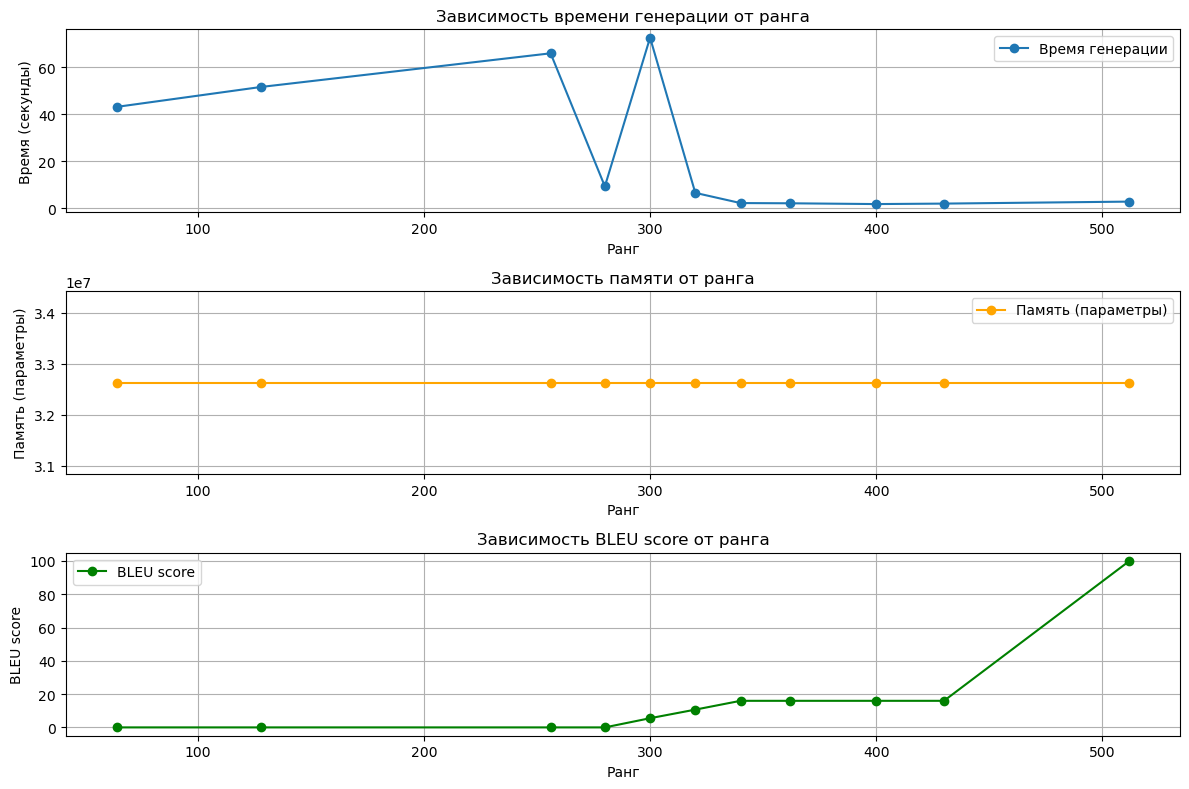

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Время
plt.subplot(3, 1, 1)
plt.plot(ranks, compressed_times, marker='o', label="Время генерации")
plt.xlabel("Ранг")
plt.ylabel("Время (секунды)")
plt.title("Зависимость времени генерации от ранга")
plt.grid(True)
plt.legend()

# Память
plt.subplot(3, 1, 2)
plt.plot(ranks, compressed_memories, marker='o', color='orange', label="Память (параметры)")
plt.xlabel("Ранг")
plt.ylabel("Память (параметры)")
plt.title("Зависимость памяти от ранга")
plt.grid(True)
plt.legend()

# Скор
plt.subplot(3, 1, 3)
plt.plot(ranks, bleu_scores, marker='o', color='green', label="BLEU score")
plt.xlabel("Ранг")
plt.ylabel("BLEU score")
plt.title("Зависимость BLEU score от ранга")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
